In [1]:
import os
import sys
thread = 8 #sys.argv[1]
os.environ["OMP_NUM_THREADS"] = str(thread) # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = str(thread) # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = str(thread) # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread) # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = str(thread) # export NUMEXPR_NUM_THREADS=6
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import matplotlib.pyplot as plt

import gpflow
import numpy as np
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, WhiteKernel, PairwiseKernel
import GPy
import gpflow
import pyro
import torch
import pyro.contrib.gp as pyrogp
import pyro.distributions as dist
import tensorflow as tf
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_backward, torch_item
from pyro.contrib.autoguide import AutoMultivariateNormal
from torch.distributions import constraints
from torch.nn import Parameter
from pyro.optim import Adam
from gpflow import posteriors
pyro.clear_param_store()
from pyro.nn.module import PyroModule
from GPR import GPR_benchmark, GPR
from gpflow import config

2023-05-15 23:57:25.263644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Expermental works

In [2]:
# %timeit
# scikit = GPR(library='scikit', kernel='laplacian', sigma = 1, length_scale=200, white_noise=1e-6)
# scikit.fit(X[:8192], y[:8192])

# %timeit
# print(np.mean(abs(y[-9000:] - scikit.predict(X[-9000:]))))



# gpy = GPR(library='gpy', kernel='gaussian', sigma = 1, length_scale=720, white_noise=1e-6, optimize = False, iterations=100)

# gpy.fit(X[:8000], y[:8000])

# a.append(np.mean(abs(y[-1000:] - gpy.predict(X[-1000:]))))


# %time
# print(np.mean(abs(y[-1000:] - gpy.predict(X[-1000:]))))

# %time
# gflow = GPR(library='gpflow', kernel='gaussian', sigma = 1, length_scale=720, white_noise=1e-6)

# gflow.fit(X[:8000], y[:8000])

# %%time
# np.mean(abs(y[-1000:] - gflow.predict(X[-1000:])))

# %%time
# pyro.clear_param_store()
# pyro_ins = GPR(library='pyro', kernel='laplacian', sigma = 1, length_scale=720, white_noise=1e-6)
# pyro.clear_param_store()
# pyro_ins.fit(X[:8000], y[:8000])

# %%time
# np.mean(abs(y[-4000:] - pyro_ins.predict(X[-4000:])))
# for k in range(2):
#     for l in range(2):
#         for i in range(13):
#             gpr_array[1, i, l+2, k].avg_mae = temp_array[1, i, l, k].avg_mae
#             gpr_array[1, i, l+2, k].avg_training_time_wall = temp_array[1, i, l, k].avg_training_time_wall
#             gpr_array[1, i, l+2, k].avg_testing_time_wall = temp_array[1, i, l, k].avg_testing_time_wall
#             gpr_array[1, i, l+2, k].avg_training_time_cpu = temp_array[1, i, l, k].avg_training_time_cpu
#             gpr_array[1, i, l+2, k].avg_testing_time_cpu = temp_array[1, i, l, k].avg_testing_time_cpu

# Results

In [3]:
threads = [i for i in range(1, 21)]
gpr_array = np.array([np.load("/home/ssunar/Thesis/data/output_data_new/GPR_thread_" + str(thread) + ".npy", allow_pickle=True) for thread in threads])

In [4]:
def array_to_latex(arr):
    """
    Converts a 2D array into a LaTeX tabular environment with scientific notation and vertical/horizontal lines
    :param arr: 2D array to convert
    :return: LaTeX code as a string
    """
    rows = []
    for row in arr:
        rows.append(" & ".join("{:.2e}".format(val) if isinstance(val, (int, float)) else str(val) for val in row) + r" \\\hline")
    latex = r"\begin{tabular}{|" + "c|" * len(arr[0]) + "}\n"
    latex += "\hline \n"
    latex += "\n".join(rows)
    latex += "\n\end{tabular}"
    return latex

In [5]:
def plot_avg_mae(gpr_array):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    for k, kernel_name in enumerate(kernel_names):
        for l, library_name in enumerate(library_names):
            if k == 0:
                alpha = 1
                ls = "-"
            else:
                alpha = 0.7
                ls = "--"
            avg_mae_array = np.zeros((13,))
            for i in range(13):
                avg_mae_array[i] = gpr_array[0, i, l, k].avg_mae
            axs.loglog(np.array([2 ** i for i in range(1, 14)]), avg_mae_array, label=library_name+"_"+kernel_name, alpha = 0.7, linestyle = ls, linewidth = 2)
            axs.set_title(f"Learning curve GPR")
            axs.set_xlabel("Sample Size")
            axs.set_ylabel("Average MAE")
            axs.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Learning_curve_GPR.png", dpi = 200)

In [6]:
def plot_avg_training(gpr_array):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["cpu_time", "wall_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_training_time[i] = gpr_array[j, i, l, k].avg_training_time_wall
                        else:
                            avg_training_time[i] = gpr_array[j, i, l, k].avg_training_time_cpu
                    axs[t].plot(np.array([2 ** i for i in range(1, 14)]), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[t].set_title(f"Training time plot GRR, Thread(s) = {thread}, Time={time_name}")
                    axs[t].set_xlabel("Sample Size")
                    axs[t].set_ylabel(f"Time in seconds")
                    axs[t].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Training_time_GPR.png", dpi = 200)

In [7]:
def plot_avg_testing(gpr_array):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["cpu_time", "wall_time"]
    threads = [1]
    

    for j, thread in enumerate(threads):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_testing_time = np.zeros((13,))
                    for i in range(13):
                        if t  == 1:
                            avg_testing_time[i] = gpr_array[j, i, l, k].avg_testing_time_wall
                        else:
                            avg_testing_time[i] = gpr_array[j, i, l, k].avg_testing_time_cpu
                    axs[t].plot(np.array([2 ** i for i in range(1, 14)]), avg_testing_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[t].set_title(f"Evaluation time plot GPR, Thread(s) = {thread}, Time={time_name}")
                    axs[t].set_xlabel("Sample Size")
                    axs[t].set_ylabel(f"Time in seconds")
                    axs[t].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Evaluation_time_GPR.png", dpi = 200)

In [8]:
def plot_scalability(gpr_array):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["wall_time", "cpu_time"]
    threads = [i for i in range(1, 21)]
    samples_idx = [9, 11, 12]
    y_lims = np.array([[0.8, 20, 110], [10, 50, 230]])
    
    

    for i, sample_idx in enumerate(samples_idx):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time= np.zeros((20,))
                    for j, thread in enumerate(threads):
                        if time_name == "wall_time":
                            avg_training_time[j-1] = gpr_array[j-1, sample_idx, l, k].avg_training_time_wall
                        else:
                            avg_training_time[j-1] = gpr_array[j-1, sample_idx, l, k].avg_training_time_cpu
                    axs[i][t].plot(np.array(threads), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[i][t].set_title(f"Training time Scalability plot GPR, Samples={2**(sample_idx+1)}, Time={time_name}")
                    axs[i][t].set_xlabel("Number of threads")
                    axs[i][t].set_ylabel(f"times in seconds")
                    axs[i][t].set_xticks([i for i in range(1, 21, 1)])
                    axs[i][t].set_ylim(0, y_lims[t, i])
                    axs[i][t].legend(loc='upper right' if t == 0 else "upper left")
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Scalability_Training_time_GPR.png", dpi = 200)

In [9]:
def plot_scalability_eval(gpr_array):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
    kernel_names = ["Laplacian", "Gaussian"]
    library_names = ["scikit-learn", "gpy", "gpflow", "pyro"]
    times_names = ["wall_time", "cpu_time"]
    threads = [i for i in range(1, 21)]
    samples_idx = [9, 11, 12]
    
    

    for i, sample_idx in enumerate(samples_idx):
        for t, time_name in enumerate(times_names):
            for l, library_name in enumerate(library_names):
                for k, kernel_name in enumerate(kernel_names):
                    avg_training_time= np.zeros((20,))
                    for j, thread in enumerate(threads):
                        if time_name == "wall_time":
                            avg_training_time[j-1] = gpr_array[j-1, sample_idx, l, k].avg_testing_time_wall
                        else:
                            avg_training_time[j-1] = gpr_array[j-1, sample_idx, l, k].avg_testing_time_cpu
                    axs[i][t].plot(np.array(threads), avg_training_time, label=library_name+"_"+kernel_name, alpha = 0.7)
                    axs[i][t].set_title(f"Evaluation time Scalability plot GPR, Samples={2**(sample_idx+1)}, Time={time_name}")
                    axs[i][t].set_xlabel("Number of threads")
                    axs[i][t].set_ylabel(f"times in seconds")
                    axs[i][t].set_xticks([i for i in range(1, 21, 1)])
                    axs[i][t].legend(loc='upper right' if t == 0 else "upper left")
    plt.tight_layout()
    plt.show()
    fig.savefig("./img/Scalability_Evaluation_time_GPR.png", dpi = 200)

# Plot table in latex format

In [10]:
a = np.empty((4, 2))
for i in range(4):
    for j in range(2):
        a[i,j] = gpr_array[0, 12, i, j].avg_mae
print(array_to_latex(a))

\begin{tabular}{|c|c|}
\hline 
1.38e-03 & 7.78e-03 \\\hline
1.14e-01 & 1.14e-01 \\\hline
9.91e-02 & 8.45e-02 \\\hline
3.23e-04 & 7.78e-03 \\\hline
\end{tabular}


# Learning curve

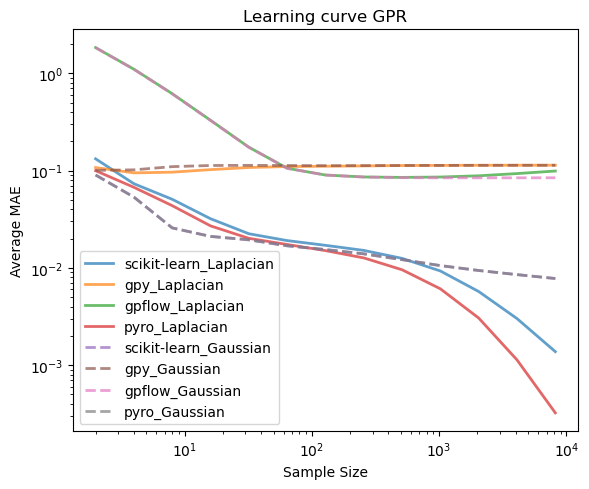

In [11]:
plot_avg_mae(gpr_array)

# Training time

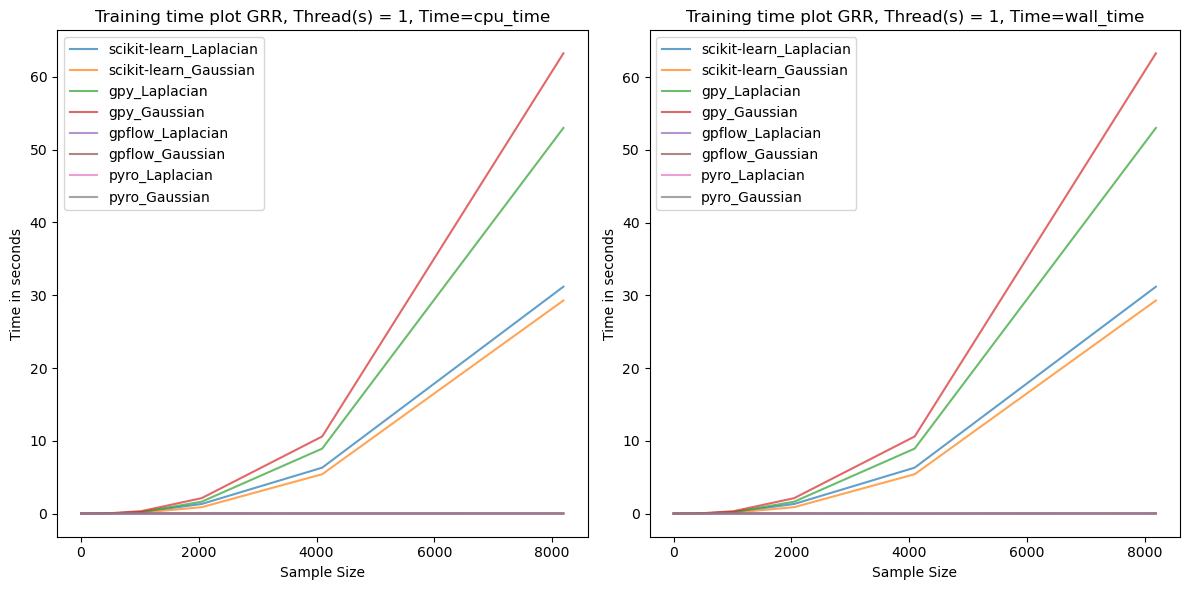

In [12]:
plot_avg_training(gpr_array)

# Evaluation time

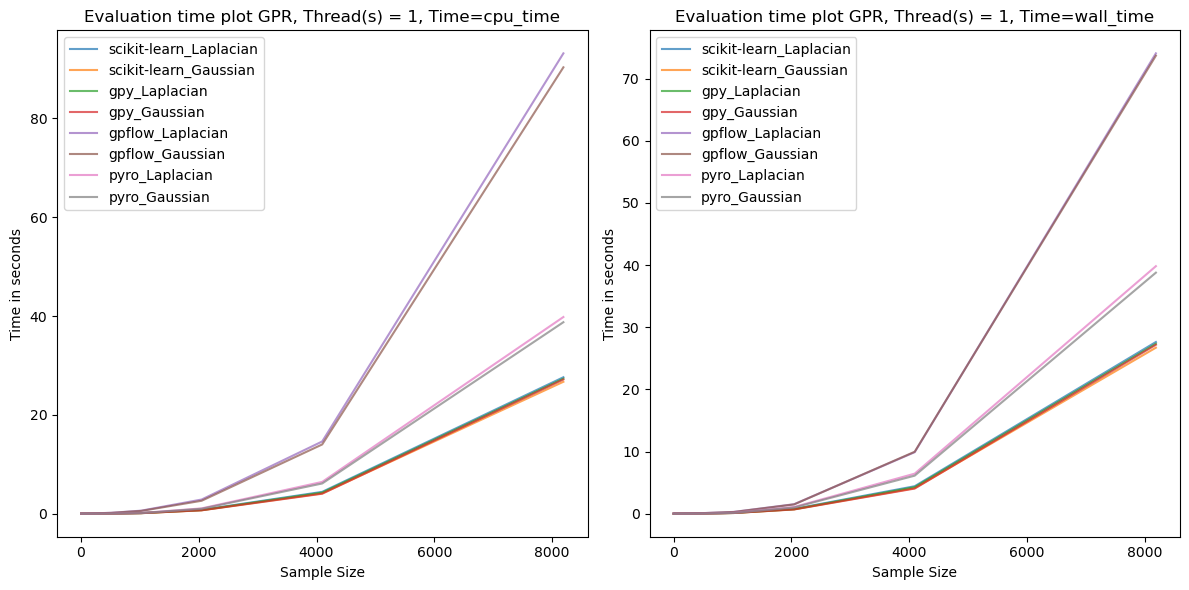

In [13]:
plot_avg_testing(gpr_array)

# Training Parallel Scalability

In [14]:
y_lims = np.array([[0.8, 20, 110], [10, 50, 170]])

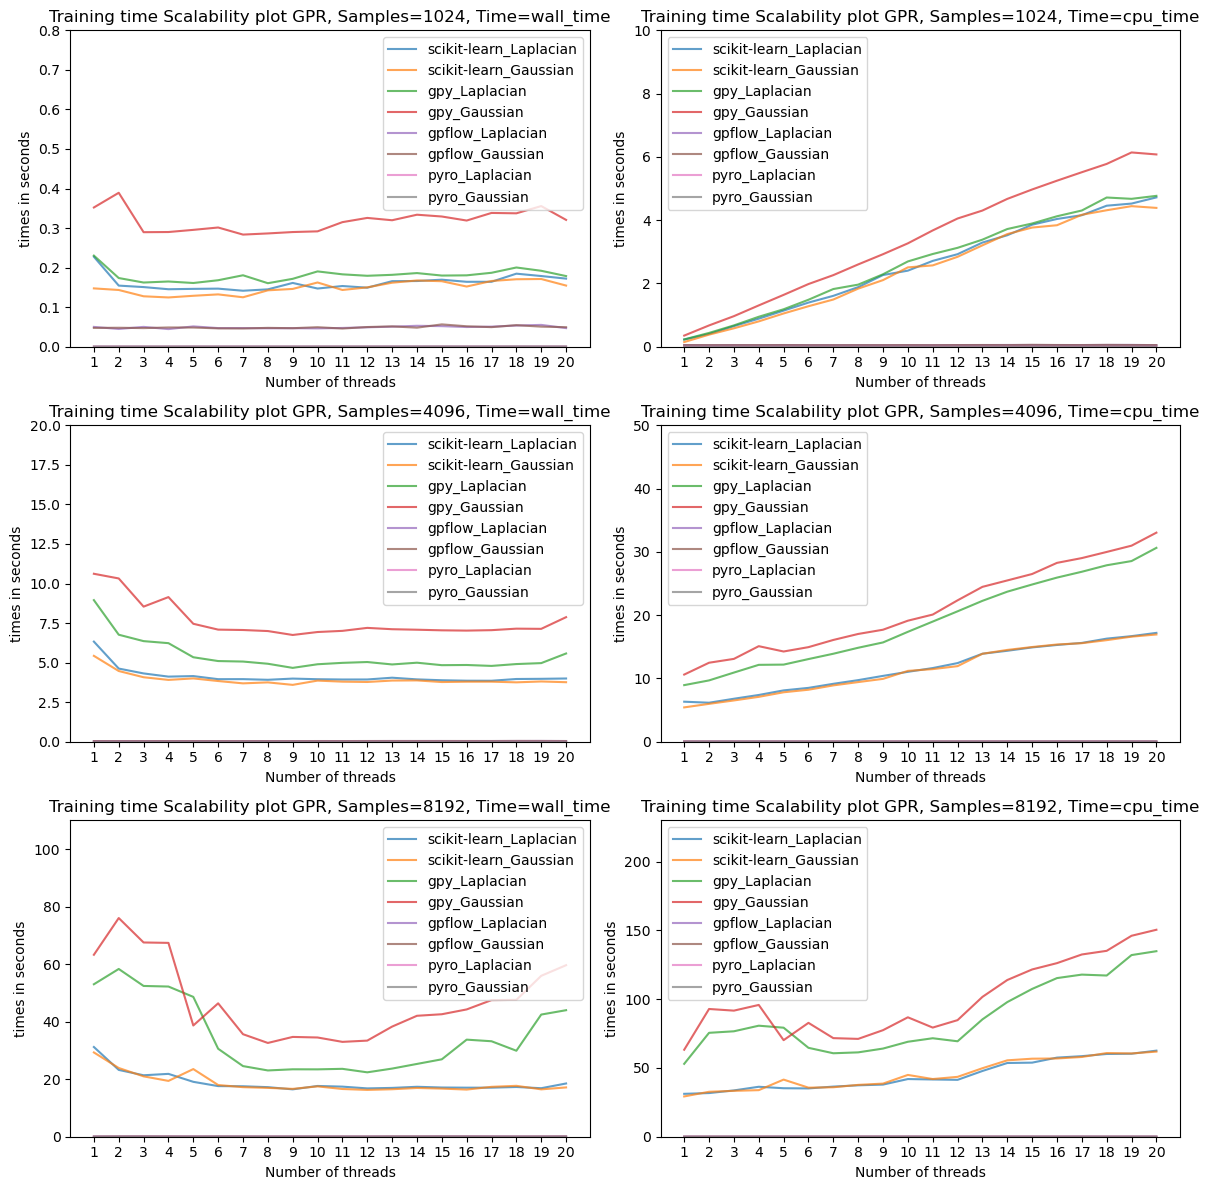

In [15]:
plot_scalability(gpr_array)

# Evalution Parallel Scalability

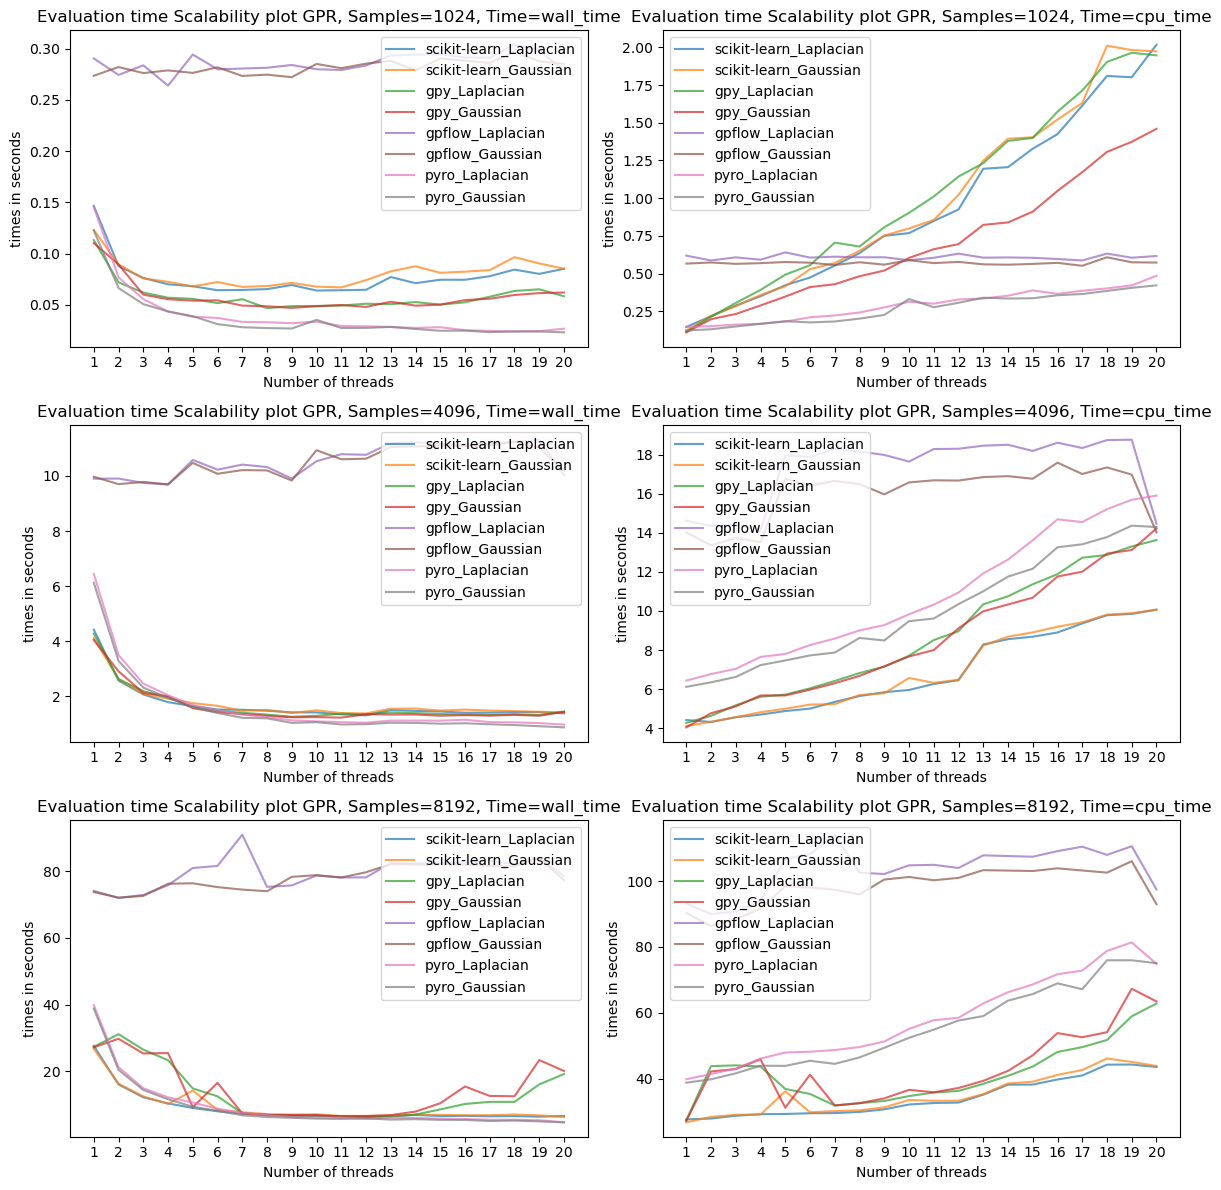

In [16]:
plot_scalability_eval(gpr_array)